# Create distribution plot

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
from scipy import stats as sstats
import os
import re
import glob
import string
from matplotlib import pyplot as plt
from xhistogram import xarray as xhist
import seaborn as sns
from tqdm.notebook import tqdm
import warnings

from funcs_support import get_filepaths,get_params,utility_print
from funcs_load import load_raws
dir_list = get_params()

In [2]:
# Load model and obs data
dss = {exp:load_raws({'varname':'prtrends','suffix':'HoAfrica','exp':exp},
                  source_dir = 'proc',force_load = True,treat_multiple={'time':'earliest'},
                     subset_params = {'start_year':slice(1981,2022),'end_year':slice(1982,2023)})
       for exp in ['amip','hist-ssp245','obs','hindcastsf']}

In [3]:
# Make sure to only keep the necessary variables (some obs products
# have more) 
vars_keep = ['prtrend','pr_std','trend_length','pr_tsslope','pr_iqr']

# Concatenate into single dataset
def prep_for_concat(ds):
    # Helps make concatenation easier, because now the names of the runs
    # don't matter anymore (because we're not matching within models)
    ds['run'] = np.arange(0,ds.sizes['run'])
    return ds

dss = {exp:xr.concat([prep_for_concat(ds[[v for v in vars_keep if v in ds]]) for mod,ds in dss[exp].items()],
                dim = pd.Index([mod for mod in dss[exp]],name='model'))
       for exp in dss}

In [4]:
# trend_length gets broadcasted; cut it back down to size
for exp in dss:
    dss[exp]['trend_length'] = dss[exp]['trend_length'].isel({k:0 for k in dss[exp].trend_length.sizes
                                                              if k not in ['start_year','end_year']},
                                                             drop=True)

In [5]:
# Get number of runs per model, at least during the Rowell period 
for exp in dss:
    dss[exp]['nruns'] = ((~np.isnan(dss[exp].prtrend.sel(start_year=1986,end_year=2004))).sum('run').
                         max(('season')))

In [6]:
# Get rid of models with no data
for exp in dss:
    dss[exp] = dss[exp].where((~(np.isnan(dss[exp].prtrend.sel(season='MAM',region='HoA-bimod',drop=True)).
                                      all(('run','start_year','end_year')))),drop=True)

In [7]:
# Subset to just LEs (more than 10 runs, here)
dss_les = {exp:ds.where(ds.nruns>=10,drop=True) for exp,ds in dss.items()}
# Add obs back in to make it easy (obs is dropped because 1 run per product)
dss_les['obs'] = dss['obs']

In [8]:
min_trend = 7 
# Get which obs product is closest to model, run mean
obs_closest_to_modelmean = {exp:np.abs(dss['obs'].where(dss['obs'].trend_length>min_trend,drop=True).isel(run=0,drop=True)['prtrend'] - 
                                      dss[exp].where(dss[exp].trend_length>min_trend,drop=True).mean(('model','run'))['prtrend']).idxmin('model',skipna=True)
                            for exp in [exp for exp in dss if exp != 'obs']}

# Fill nans with just a random model, otherwise sel doesn't work
# below
obs_closest_to_modelmean = {exp:ds.where(~pd.isnull(ds),
                                                          'CHIRPS')
                            for exp,ds in obs_closest_to_modelmean.items()}


## Calculate quantiles and ranks

### Quantile calculation

In [9]:
def percentileof_alongdim(da,da_score,nan_policy='omit'):
    ''' apply_ufunc-compatible wrapper of percentileofscore
    '''

    return sstats.percentileofscore(da.flatten(),
                                    da_score,
                                    nan_policy=nan_policy)*0.01

In [10]:
# Add mean across GPCC-full, CHIRPS, GPCP, from main text figures 
dss['obs'] = xr.concat([dss['obs'],
                        (dss['obs'].sel(model=['GPCC-full','CHIRPS','GPCP']).mean('model').
                        expand_dims({'model':['mean3']}))],
                       dim='model')

In [11]:
# Calculate what quantile of model-run distributions observed trends are
pcts = {exp:xr.apply_ufunc(percentileof_alongdim,
                      dss[exp].prtrend.where(dss[exp].trend_length>min_trend,drop=True),
                      dss['obs'].prtrend.where(dss['obs'].trend_length>min_trend,drop=True).isel(run=0).rename({'model':'obsmod'}),
                      input_core_dims = [['model','run'],[]],
                      vectorize=True,join='inner') 
        for exp in [exp for exp in dss if exp != 'obs']}

# Add percentile of obs closest to model mean
for exp in pcts:
    pcts[exp] = xr.concat([pcts[exp],
                           (pcts[exp].sel(obsmod = (obs_closest_to_modelmean[exp].
                                                   sel(season=pcts[exp].season))).drop_vars('obsmod').
                            expand_dims({'obsmod':['closest']}))],
                          dim='obsmod')

### Rank calculation 
(See, e.g., [Suarez-Gutierrez et al., 2021](https://doi.org/10.1007/s00382-021-05821-w))

In [12]:
def rank_within(xobs,xmods):
    ''' Get rank of an obs within a different distribution 

    Set up for :py:meth:`xr.apply_ufunc()`
    '''
    
    # Flatten into a numpy array
    xmods = xmods.flatten()

    if (~np.isnan(xobs)) and np.any(~np.isnan(xmods)):

        # Remove individual nans (unclear what rank means
        # in the presence of nans)
        xmods = xmods[~np.isnan(xmods)]
    
        # Sort
        xmods = np.sort(xmods)
    
        # Get rank (np.argmax() stops counting after the 
        # first True, so this gets the first index that's 
        # greater than xobs, or, the rank of xobs in the 
        # distribution of [*xmods,xobs]
        try:
            loc_within = xmods > xobs
    
            if np.any(loc_within):
                relrank = np.argmax(xmods>xobs) / len(xmods)
            else:
                # If all False, then obs are higher than 
                # all mod values, but np.argmax() returns
                # 0 - set to 1 instead then
                relrank = 1
        except ValueError:
            relrank = np.nan
    else:
        relrank = np.nan
    
    return relrank

In [13]:
var_list = ['prtrend','pr_tsslope']
ranks = {exp:xr.apply_ufunc(rank_within,
                   (dss['obs'][[v for v in dss[exp] if v in var_list]].
                        isel(run=0).rename({'model':'obsmod'})),
                   (dss[exp][[v for v in dss[exp] if v in var_list]]),
                   input_core_dims = [[],['model','run']],
                          vectorize=True,join='inner')
         for exp in [exp for exp in dss if exp != 'obs']}

for exp in ranks:
    ranks[exp]['trend_length'] = ranks[exp]['end_year'] - ranks[exp]['start_year']

In [ ]:
%%time
# Get perfect model ranks 
ranks_pmod = {exp:xr.apply_ufunc(rank_within,
                                 (dss[exp][[v for v in dss[exp] if v in var_list]].
                                  stack(allv=['model','run']).dropna('allv',how='all').drop_vars(['model','run','allv'])),
                                 dss[exp][[v for v in dss[exp] if v in var_list]],
                                 input_core_dims = [[],['model','run']],
                                 vectorize=True,join='inner')
              for exp in [exp for exp in dss if exp != 'obs']}

In [ ]:
# Save temporary files 
for exp in ranks_pmod:
    ranks_pmod[exp].attrs['SOURCE'] = 'create_figure4.ipynb'
    ranks_pmod[exp].attrs['DESCRIPTION'] = 'perfect model trend ranks across models, runs'
    output_fn = (dir_list['aux']+'prtrendrank_'+exp+'_ALLMODS_allruns_'+
                 str(ranks_pmod[exp]['start_year'].min().values)+'-'+
                 str(ranks_pmod[exp]['end_year'].max().values)+'_HoAfrica.nc')
    ranks_pmod[exp].to_netcdf(output_fn)
    print(output_fn+' saved!')

In [20]:
# Load temporary files
ranks_pmod = dict()
for exp in ['amip','hist-ssp245','hindcastsf']:
    fn = glob.glob(dir_list['aux']+'prtrendrank_'+exp+'_ALLMODS_allruns_*.nc')
    ranks_pmod[exp] = xr.open_dataset(fn[0])

In [21]:
# Add back in trend_length
for exp in ranks_pmod:
    ranks_pmod[exp]['trend_length'] = ranks_pmod[exp]['end_year'] - ranks_pmod[exp]['start_year']

## Plot code

### Rank histogram 
(See, e.g., [Hamill 2001](hamill_interpretation_2001))

/dx02/kschwarz/project_data/future_stability/figures/figureS17.pdf saved!
/dx02/kschwarz/project_data/future_stability/figures/figureS17.png saved!


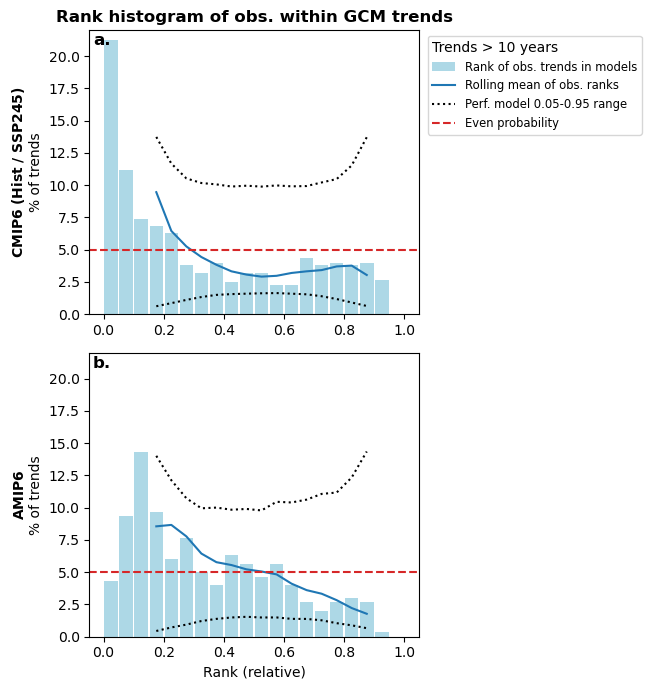

In [22]:
save_fig = True
output_fn = dir_list['figs']+'figureS17'


exp = 'hist-ssp245'
var = 'prtrend'
obsmod = 'mean3'
normalize = True

trend_lims = [10,40]

nbins = 20

hist_slope_win = 6

selblock = {'region':'overlap','season':'MAM'}

obs_mods = ['mean3']
mod_names = {mod:mod for mod in obs_mods}
mod_names['mean3'] = 'Rank histogram of obs. within GCM trends'

exp_labels = {'amip':'AMIP6',
              'hist-ssp245':r'CMIP6\ (Hist\ /\ SSP245)',
              'hist-ssp585':r'CMIP6\ (Hist\ /\ SSP585)',
               'hindcasts-lead0':r'NMME\ (lead\ 0.5\ m)',
               'hindcasts-lead13':r'NMME\ (lead\ 1.5-3.5\ m)',
               'hindcasts-lead46':r'NMME\ (lead\ 4.5-6.5\ m)'}


#----------- Setup -----------
bins = np.arange(0,1.01,1/nbins)

#----------- Plot -----------
fig = plt.figure(figsize=(6.5,7))
#fig = plt.figure(figsize=(4,7))
for mod,col_idx in zip(obs_mods,np.arange(0,len(obs_mods))):
    for exp,row_idx in zip(['hist-ssp245','amip'],np.arange(0,2)):
        ax = plt.subplot(2,len(obs_mods),(row_idx)*len(obs_mods) + col_idx+1)
 
        #----------- Setup data -----------
        plot_data = {'hist':ranks[exp].sel(obsmod=mod),
                     'dash':ranks_pmod[exp]}
        for typ in plot_data:
            # Subset by region, season
            plot_data[typ] = plot_data[typ].sel(**selblock)
            # Subset by desired trend length
            plot_data[typ] = plot_data[typ].where((plot_data[typ]['trend_length']>=trend_lims[0]) & 
                                                  (plot_data[typ]['trend_length']<=trend_lims[1]),
                                                  drop=True)
            plot_data[typ] = plot_data[typ][var]
            # Get data as histograms
            plot_data[typ] = xhist.histogram(plot_data[typ],
                                             bins = bins,
                                             dim=['start_year','end_year'])
        
            # If normalize histograms
            if normalize:
                plot_data[typ] = plot_data[typ] / plot_data[typ].sum(var+'_bin')*100
        
        
        #----------- Plot -----------
        # Plot histogram
        h = plt.bar(bins[0:-1]+np.diff(bins)[0]/2,
                plot_data['hist'],
                width = np.diff(bins)[0]*0.9,
               color='lightblue',
                   label = 'Rank of obs. trends in models')

        # Plot histogram slope
        h0 = plot_data['hist'].rolling({var+'_bin':hist_slope_win},center=True).mean().plot(color='tab:blue',
                                                                                            label = 'Rolling mean of obs. ranks')
        
        # Plot reference perfect model 
        #h1 = plot_data['dash'].quantile(0.95,dim='allv')[1:-1].plot(color='k',linestyle=':',label='Perf. model 0.05-0.95 range')
        #plot_data['dash'].quantile(0.05,dim='allv')[1:-1].plot(color='k',linestyle=':')
        h1 = plot_data['dash'].quantile(0.95,dim='allv').rolling({var+'_bin':hist_slope_win},center=True).mean().plot(color='k',linestyle=':',label='Perf. model 0.05-0.95 range')
        plot_data['dash'].quantile(0.05,dim='allv').rolling({var+'_bin':hist_slope_win},center=True).mean().plot(color='k',linestyle=':')
        
        # Plot flat line
        h2 = ax.axhline(100/nbins,color='tab:red',linestyle='--',label='Even probability')
        
        #----------- Annotations -----------
        ax.set_ylim([0,22])

        if row_idx == 1:
            ax.set_xlabel('Rank (relative)')
        else:
            ax.set_xlabel('')
        if col_idx == 0:
            ax.set_ylabel(r'$\mathbf{'+exp_labels[exp]+'}$'+'\n'+r'% of trends')
        else:
            ax.set_ylabel('')

        if row_idx == 0:
            ax.set_title(mod_names[mod],fontweight='bold')
        else:
            ax.set_title('')

        if (col_idx == 0) and (row_idx == 0):
            ax.legend(handles=[h,h0[0],h1[0],h2],
                      bbox_to_anchor = (1.01,1),
                      loc = 'upper left',
                     title='Trends > '+str(trend_lims[0])+' years',
                     alignment='left',fontsize='small')

        # Subplot lettering
        ax.annotate(string.ascii_lowercase[(row_idx)*len(obs_mods) + col_idx]+'.',
                        [0.01,0.99],xycoords='axes fraction',
                        va='top',ha='left',fontsize=12,fontweight='bold')

#--------- Save ---------
if save_fig:
    plt.tight_layout()
    utility_print(output_fn)

### Additional figure split out by obs. product

/dx02/kschwarz/project_data/future_stability/figures/EXTRAfigureS17.pdf saved!
/dx02/kschwarz/project_data/future_stability/figures/EXTRAfigureS17.png saved!


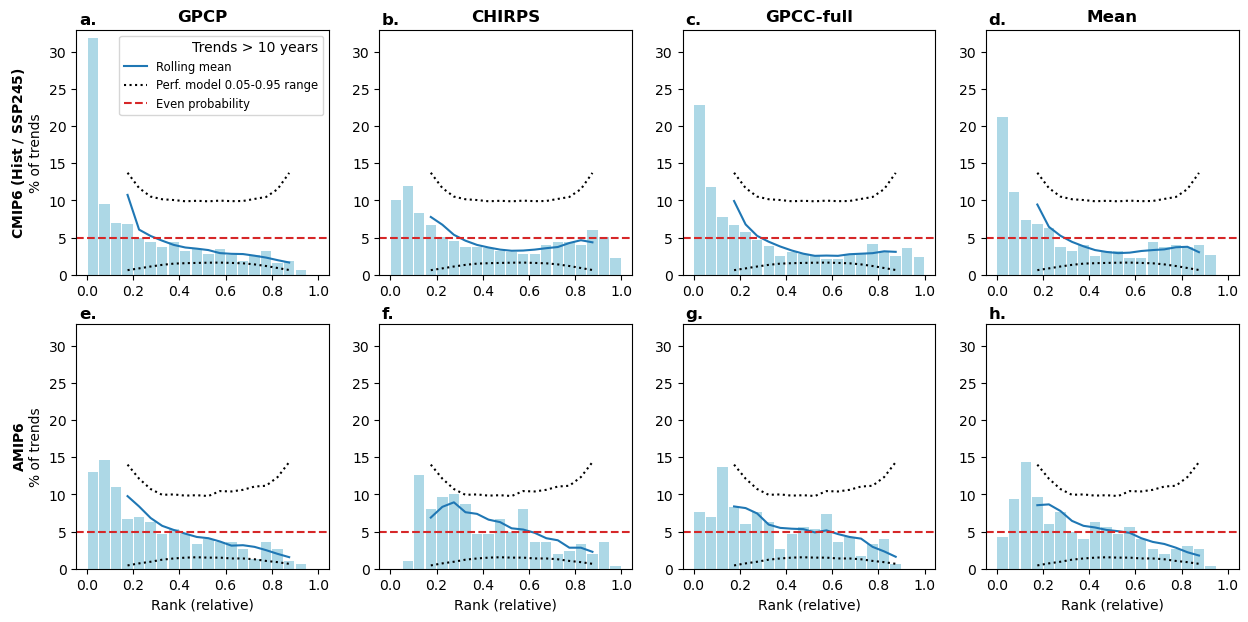

In [23]:
save_fig = True
output_fn = dir_list['figs']+'EXTRAfigureS17'


exp = 'hist-ssp245'
var = 'prtrend'
obsmod = 'mean3'
normalize = True

trend_lims = [10,40]

nbins = 20

hist_slope_win = 6

selblock = {'region':'overlap','season':'MAM'}

obs_mods = ['GPCP','CHIRPS','GPCC-full','mean3']
mod_names = {mod:mod for mod in obs_mods}
mod_names['mean3'] = 'Mean'

exp_labels = {'amip':'AMIP6',
              'hist-ssp245':r'CMIP6\ (Hist\ /\ SSP245)',
              'hist-ssp585':r'CMIP6\ (Hist\ /\ SSP585)',
               'hindcasts-lead0':r'NMME\ (lead\ 0.5\ m)',
               'hindcasts-lead13':r'NMME\ (lead\ 1.5-3.5\ m)',
               'hindcasts-lead46':r'NMME\ (lead\ 4.5-6.5\ m)'}


#----------- Setup -----------
bins = np.arange(0,1.01,1/nbins)

#----------- Plot -----------
fig = plt.figure(figsize=(15,7))
#fig = plt.figure(figsize=(4,7))
for mod,col_idx in zip(obs_mods,np.arange(0,len(obs_mods))):
    for exp,row_idx in zip(['hist-ssp245','amip'],np.arange(0,2)):
        ax = plt.subplot(2,len(obs_mods),(row_idx)*len(obs_mods) + col_idx+1)
 
        #----------- Setup data -----------
        plot_data = {'hist':ranks[exp].sel(obsmod=mod),
                     'dash':ranks_pmod[exp]}
        for typ in plot_data:
            # Subset by region, season
            plot_data[typ] = plot_data[typ].sel(**selblock)
            # Subset by desired trend length
            plot_data[typ] = plot_data[typ].where((plot_data[typ]['trend_length']>=trend_lims[0]) & 
                                                  (plot_data[typ]['trend_length']<=trend_lims[1]),
                                                  drop=True)
            plot_data[typ] = plot_data[typ][var]
            # Get data as histograms
            plot_data[typ] = xhist.histogram(plot_data[typ],
                                             bins = bins,
                                             dim=['start_year','end_year'])
        
            # If normalize histograms
            if normalize:
                plot_data[typ] = plot_data[typ] / plot_data[typ].sum(var+'_bin')*100
        
        
        #----------- Plot -----------
        # Plot histogram
        plt.bar(bins[0:-1]+np.diff(bins)[0]/2,
                plot_data['hist'],
                width = np.diff(bins)[0]*0.9,
               color='lightblue')

        # Plot histogram slope
        h0 = plot_data['hist'].rolling({var+'_bin':hist_slope_win},center=True).mean().plot(color='tab:blue',
                                                                                            label = 'Rolling mean')
        
        # Plot reference perfect model 
        #h1 = plot_data['dash'].quantile(0.95,dim='allv')[1:-1].plot(color='k',linestyle=':',label='Perf. model 0.05-0.95 range')
        #plot_data['dash'].quantile(0.05,dim='allv')[1:-1].plot(color='k',linestyle=':')
        h1 = plot_data['dash'].quantile(0.95,dim='allv').rolling({var+'_bin':hist_slope_win},center=True).mean().plot(color='k',linestyle=':',label='Perf. model 0.05-0.95 range')
        plot_data['dash'].quantile(0.05,dim='allv').rolling({var+'_bin':hist_slope_win},center=True).mean().plot(color='k',linestyle=':')
        
        # Plot flat line
        h2 = ax.axhline(100/nbins,color='tab:red',linestyle='--',label='Even probability')
        
        #----------- Annotations -----------
        ax.set_ylim([0,33])

        if row_idx == 1:
            ax.set_xlabel('Rank (relative)')
        else:
            ax.set_xlabel('')
        if col_idx == 0:
            ax.set_ylabel(r'$\mathbf{'+exp_labels[exp]+'}$'+'\n'+r'% of trends')
        else:
            ax.set_ylabel('')

        if row_idx == 0:
            ax.set_title(mod_names[mod],fontweight='bold')
        else:
            ax.set_title('')

        if (col_idx == 0) and (row_idx == 0):
            ax.legend(handles=[h0[0],h1[0],h2],
                     title='Trends > '+str(trend_lims[0])+' years',
                     alignment='right',fontsize='small')

        # Subplot lettering
        ax.annotate(string.ascii_lowercase[(row_idx)*len(obs_mods) + col_idx]+'.',
                        [0.01,1.01],xycoords='axes fraction',
                        va='bottom',ha='left',fontsize=12,fontweight='bold')

#--------- Save ---------
if save_fig:
    utility_print(output_fn)